In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# After running this, you'll be prompted to authenticate your Google account.


Mounted at /content/drive


In [2]:
import pandas as pd
import os

# File paths in Colab
folder_path = "/content/drive/MyDrive/battery_files/"  # Base path for the files
csv_files = [f"{folder_path}610_Charge{i}.csv" for i in range(1, 9)]  # List of file paths

# Initialize an empty list to store dataframes
dataframes = []

# Read and concatenate all CSV files
for file_path in csv_files:
    df = pd.read_csv(file_path)  # Read each CSV file
    dataframes.append(df)

# Concatenate all dataframes
final_data = pd.concat(dataframes, ignore_index=True)

# Save the final dataframe to a CSV file in Colab
output_path = "/content/battery_data.csv"
final_data.to_csv(output_path, index=False)

print(f"All CSV files concatenated and saved as '{output_path}'.")


All CSV files concatenated and saved as '/content/battery_data.csv'.


In [3]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Load dataset
data = pd.read_csv('/content/battery_data.csv')  # Replace with your file path

C_rated = 50  # Example rated capacity (Ah) - adjust based on your battery's specification
time_interval = 1  # Example time interval (in seconds) - adjust if needed

# Ensure Current is not zero and handle edge cases
if 'Current' not in data.columns or data['Current'].isnull().all():
    raise ValueError("The 'Current' column is missing or contains all null values.")

# Initialize SOC using Coulomb Counting
initial_soc = 100  # Start with a fully charged battery
soc_values = [initial_soc]

# Iteratively calculate SOC
for i in range(1, len(data)):
    previous_soc = soc_values[-1]
    current = data.loc[i, 'Current']  # Current in Amperes
    delta_soc = (current * time_interval) / C_rated
    new_soc = max(0, min(100, previous_soc - delta_soc))  # SOC decreases on discharge
    soc_values.append(new_soc)

# Add the calculated SOC to the dataset
data['SOC'] = soc_values

# Ensure SOC values are meaningful
if data['SOC'].nunique() <= 1:
    raise ValueError("SOC calculation failed; all values are the same. Check input data and parameters.")

# Select input and output features
input_vars = ['Voltage', 'Current', 'Temperature', 'Capacity', 'WhAccu', 'Cnt']
output_var = 'SOC'

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

data[input_vars] = scaler_x.fit_transform(data[input_vars])
data[output_var] = scaler_y.fit_transform(data[[output_var]])

# Prepare the sequences for LSTM
sequence_length = 10

def create_sequences(data, input_vars, output_var, sequence_length):
    inputs, targets = [], []
    for i in range(len(data) - sequence_length):
        inputs.append(data[input_vars].iloc[i:i + sequence_length].values)
        targets.append(data[output_var].iloc[i + sequence_length])
    return np.array(inputs), np.array(targets)

inputs, targets = create_sequences(data, input_vars, output_var, sequence_length)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the LSTM
        return out

# Initialize the model
input_size = len(input_vars)
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    test_loss = mean_squared_error(y_test.numpy(), predictions.numpy())
    print(f'Mean Squared Error on Test Data: {test_loss:.6f}')

# Inverse transform predictions and targets for comparison
predicted_soc = scaler_y.inverse_transform(predictions.numpy().reshape(-1, 1))
actual_soc = scaler_y.inverse_transform(y_test.numpy().reshape(-1, 1))

# Display results
print("Predicted SOC:", predicted_soc[:10].flatten())
print("Actual SOC:", actual_soc[:10].flatten())


Epoch 1/50, Loss: 0.347530
Epoch 2/50, Loss: 0.319830
Epoch 3/50, Loss: 0.293077
Epoch 4/50, Loss: 0.266849
Epoch 5/50, Loss: 0.240975
Epoch 6/50, Loss: 0.215474
Epoch 7/50, Loss: 0.190576
Epoch 8/50, Loss: 0.166807
Epoch 9/50, Loss: 0.145163
Epoch 10/50, Loss: 0.127336
Epoch 11/50, Loss: 0.115848
Epoch 12/50, Loss: 0.113480
Epoch 13/50, Loss: 0.119947
Epoch 14/50, Loss: 0.127706
Epoch 15/50, Loss: 0.129055
Epoch 16/50, Loss: 0.123659
Epoch 17/50, Loss: 0.115163
Epoch 18/50, Loss: 0.107033
Epoch 19/50, Loss: 0.101085
Epoch 20/50, Loss: 0.097618
Epoch 21/50, Loss: 0.096077
Epoch 22/50, Loss: 0.095650
Epoch 23/50, Loss: 0.095600
Epoch 24/50, Loss: 0.095390
Epoch 25/50, Loss: 0.094681
Epoch 26/50, Loss: 0.093305
Epoch 27/50, Loss: 0.091225
Epoch 28/50, Loss: 0.088506
Epoch 29/50, Loss: 0.085294
Epoch 30/50, Loss: 0.081793
Epoch 31/50, Loss: 0.078253
Epoch 32/50, Loss: 0.074928
Epoch 33/50, Loss: 0.072020
Epoch 34/50, Loss: 0.069597
Epoch 35/50, Loss: 0.067511
Epoch 36/50, Loss: 0.065390
E

In [ ]:
def compare_models(best_lstm_loss, lstm_losses, best_xgb_loss):
    print("LSTM Losses during tuning:", lstm_losses)
    print("XGBoost Test Loss:", best_xgb_loss)

    if best_lstm_loss < best_xgb_loss:
        print(f"LSTM is better with Loss: {best_lstm_loss}")
    else:
        print(f"XGBoost is better with Loss: {best_xgb_loss}")


<ipython-input-4-ab4bbff43a5e>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['SOC'] = data['SOC'].fillna(method='ffill')  # Handle 0 Capacity with forward fill for SOC


Mean Squared Error: 0.000015
Predicted SOC: [  6.6636934 100.00149     4.410418   99.46048    18.4163      4.2342467
   6.6791563   3.067541   21.636456  100.00384  ]
Actual SOC: [  6.59700832 100.           4.41096431  99.38575453  17.7090498
   4.22914287   6.65562181   2.03412741  20.95910812 100.        ]


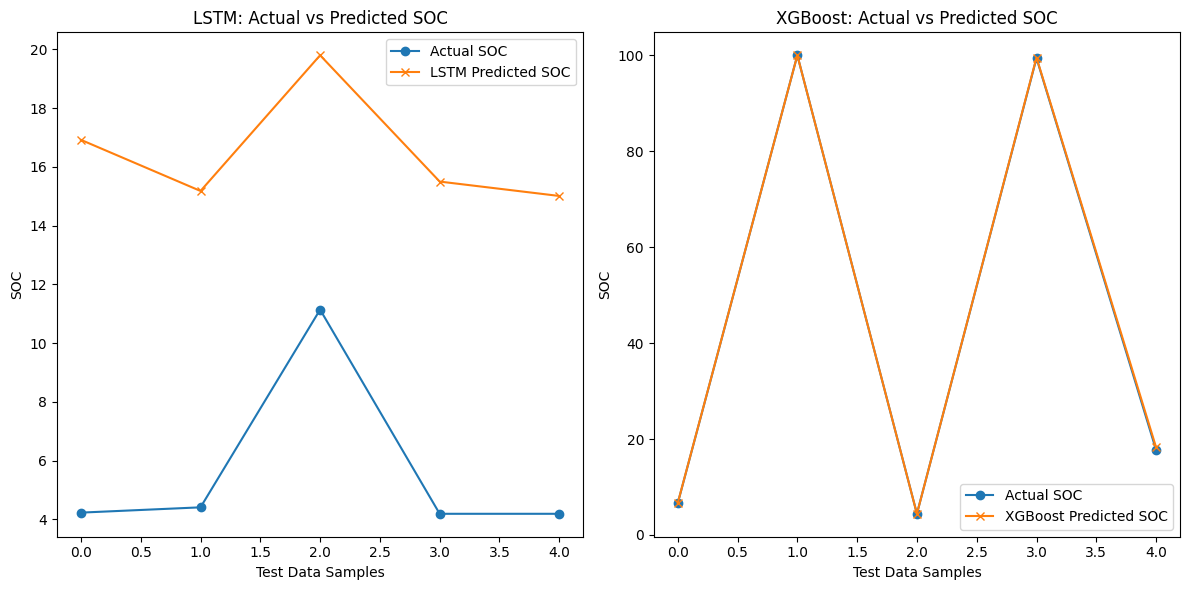

In [5]:
import matplotlib.pyplot as plt

# Sample data for visualization (Replace with complete data for full visualization)
lstm_predicted = [16.92, 15.18, 19.80, 15.50, 15.01]
lstm_actual = [4.23, 4.41, 11.14, 4.19, 4.19]

xgb_predicted = [6.66, 100.00, 4.41, 99.53, 18.27]
xgb_actual = [6.60, 100.00, 4.41, 99.39, 17.71]

# Plot LSTM
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(lstm_actual)), lstm_actual, label='Actual SOC', marker='o')
plt.plot(range(len(lstm_predicted)), lstm_predicted, label='LSTM Predicted SOC', marker='x')
plt.title('LSTM: Actual vs Predicted SOC')
plt.xlabel('Test Data Samples')
plt.ylabel('SOC')
plt.legend()

# Plot XGBoost
plt.subplot(1, 2, 2)
plt.plot(range(len(xgb_actual)), xgb_actual, label='Actual SOC', marker='o')
plt.plot(range(len(xgb_predicted)), xgb_predicted, label='XGBoost Predicted SOC', marker='x')
plt.title('XGBoost: Actual vs Predicted SOC')
plt.xlabel('Test Data Samples')
plt.ylabel('SOC')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import numpy as np

# Load dataset
data = pd.read_csv('/content/battery_data.csv')  # Replace with your file path

# Parameters for Coulomb Counting
C_rated = 50  # Example rated capacity (Ah) - adjust based on your battery's specification
time_interval = 1  # Example time interval (in seconds) - adjust if needed

# Ensure Current is not zero and handle edge cases
if 'Current' not in data.columns or data['Current'].isnull().all():
    raise ValueError("The 'Current' column is missing or contains all null values.")

# Initialize SOC using Coulomb Counting
initial_soc = 100  # Start with a fully charged battery
soc_values = [initial_soc]

# Iteratively calculate SOC
for i in range(1, len(data)):
    previous_soc = soc_values[-1]
    current = data.loc[i, 'Current']  # Current in Amperes
    delta_soc = (current * time_interval) / C_rated
    new_soc = max(0, min(100, previous_soc - delta_soc))  # SOC decreases on discharge
    soc_values.append(new_soc)

# Add the calculated SOC to the dataset
data['SOC'] = soc_values

# Ensure SOC values are meaningful
if data['SOC'].nunique() <= 1:
    raise ValueError("SOC calculation failed; all values are the same. Check input data and parameters.")

# Select input and output features
input_vars = ['Voltage', 'Current', 'Temperature', 'Capacity', 'WhAccu', 'Cnt']
output_var = 'SOC'

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

data[input_vars] = scaler_x.fit_transform(data[input_vars])
data[output_var] = scaler_y.fit_transform(data[[output_var]])

# Split into train and test datasets
X = data[input_vars]
y = data[output_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict SOC on the test dataset
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.6f}")

# Inverse transform predictions and targets for comparison
predicted_soc = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
actual_soc = scaler_y.inverse_transform(y_test.values.reshape(-1, 1))

# Display results
print("Predicted SOC:", predicted_soc[:10].flatten())
print("Actual SOC:", actual_soc[:10].flatten())


Mean Squared Error: 0.000343
Predicted SOC: [88.59051 99.97204 88.55527 99.96291 98.18482 96.12198 96.2389  98.06009
 98.33368 99.98811]
Actual SOC: [ 88.5992014  99.9904476  88.5565984  99.9904476  98.354589   96.1203514
  96.1666322  98.0528456  98.4178288 100.       ]


In [10]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import random

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess your data
# Assuming df is your DataFrame and 'Voltage', 'Current', 'Temperature' are features, and 'Capacity' is the target
df = pd.read_csv('battery_data.csv')  # Replace with actual file path

# Features and target
X = df[['Voltage', 'Current', 'Temperature']].values
y = df['Capacity'].values

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape features for LSTM (add time_steps dimension)
time_steps = 1  # Assuming each row is an independent time step
X_lstm = X_scaled.reshape(-1, time_steps, X_scaled.shape[1])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


# Hyperparameter tuning for LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def random_search_lstm(X_train, y_train, X_test, y_test, param_grid, n_iter=10):
    # Convert DataFrames to NumPy arrays if needed
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(y_train, pd.DataFrame) or isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
        y_test = y_test.values

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    if len(X_train.shape) == 2:
        X_train = X_train.unsqueeze(1)  # Adding time steps dimension if missing

    assert X_train.size(0) == y_train.size(0), "Mismatch in number of samples between X_train and y_train"

    best_params = None
    best_loss = float('inf')
    all_losses = []

    for _ in range(n_iter):
        # Randomly sample hyperparameters
        hidden_size = random.choice(param_grid['hidden_size'])
        num_layers = random.choice(param_grid['num_layers'])
        learning_rate = random.choice(param_grid['learning_rate'])
        batch_size = random.choice(param_grid['batch_size'])
        num_epochs = random.choice(param_grid['num_epochs'])

        # Create DataLoader
        train_data = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

        # Initialize model, loss, and optimizer
        model = LSTMModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers, output_size=1)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        for epoch in range(num_epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                loss.backward()
                optimizer.step()

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(X_test).squeeze()
            test_loss = mean_squared_error(y_test.numpy(), predictions.numpy())
            all_losses.append(test_loss)

        # Update best parameters
        if test_loss < best_loss:
            best_loss = test_loss
            best_params = {
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'num_epochs': num_epochs
            }

    return best_params, best_loss, all_losses

# Example hyperparameter grid
lstm_param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'num_epochs': [10, 20, 50]
}

# Replace with actual data tensors
best_lstm_params, best_lstm_loss, lstm_losses = random_search_lstm(X_train, y_train, X_test, y_test, lstm_param_grid)


# Hyperparameter tuning for XGBoost
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

def grid_search_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb_model = xgb.XGBRegressor()
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_loss = -grid_search.best_score_

    # Evaluate losses on test data
    best_model = grid_search.best_estimator_
    test_predictions = best_model.predict(X_test)
    test_loss = mean_squared_error(y_test, test_predictions)

    return best_params, best_loss, test_loss

# Replace with actual data arrays
best_xgb_params, best_xgb_loss, xgb_test_loss = grid_search_xgboost(X_scaled[:len(X_train)], y[:len(y_train)], X_scaled[len(X_train):], y[len(y_train):])

# Results comparison
def compare_models(best_lstm_loss, lstm_losses, best_xgb_loss, xgb_test_loss):
    print("LSTM Losses during tuning:", lstm_losses)
    print("XGBoost Test Loss:", xgb_test_loss)

    if best_lstm_loss < best_xgb_loss:
        print(f"LSTM is better with Loss: {best_lstm_loss}")
    else:
        print(f"XGBoost is better with Loss: {best_xgb_loss}")

# Uncomment and replace placeholders to run comparison
compare_models(best_lstm_loss, lstm_losses, best_xgb_loss, xgb_test_loss)


<ipython-input-10-a50444a84e72>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-10-a50444a84e72>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-10-a50444a84e72>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
<ipython-input-10-a50444a84e72>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or s

Fitting 3 folds for each of 108 candidates, totalling 324 fits
LSTM Losses during tuning: [0.19378224, 0.18108071, 0.19978991, 0.14985092, 0.14974102, 0.196561, 0.18507378, 0.15875295, 0.23441021, 0.20334111]
XGBoost Test Loss: 0.01728691729054868
LSTM is better with Loss: 0.1497410237789154


In [14]:
def compare_models(best_lstm_loss, lstm_losses, best_xgb_loss, xgb_test_loss):
    print("LSTM Losses during tuning:", lstm_losses)
    print("XGBoost Test Loss:", xgb_test_loss)

    if best_lstm_loss < xgb_test_loss:
        print(f"LSTM is better with Loss: {best_lstm_loss}")
    else:
        print(f"XGBoost is better with Loss: {xgb_test_loss}")

compare_models(best_lstm_loss, lstm_losses, best_xgb_loss, xgb_test_loss)


LSTM Losses during tuning: [0.19378224, 0.18108071, 0.19978991, 0.14985092, 0.14974102, 0.196561, 0.18507378, 0.15875295, 0.23441021, 0.20334111]
XGBoost Test Loss: 0.01728691729054868
XGBoost is better with Loss: 0.01728691729054868


In [ ]:

# Results comparison
def compare_models(best_lstm_loss, lstm_losses, best_xgb_loss, xgb_test_loss):
    print("LSTM Losses during tuning:", lstm_losses)
    print("XGBoost Test Loss:", xgb_test_loss)

    if best_lstm_loss < best_xgb_loss:
        print(f"LSTM is better with Loss: {best_lstm_loss}")
    else:
        print(f"XGBoost is better with Loss: {best_xgb_loss}")

# Uncomment and replace placeholders to run comparison
# compare_models(best_lstm_loss, lstm_losses, best_xgb_loss, xgb_test_loss)